In [1]:
%cd /Users/nicola/Desktop/sigoptim/kernel_hedge

import sigkernel
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import src.Ito_SigKer
from src.kernel_hedger import SigKernelHedger, KernelCompute, augment_with_time

if torch.cuda.is_available(): 
  device = 'cuda'
else: 
  device = 'cpu'

print('device:', device)

%matplotlib inline

/Users/nicola/Desktop/sigoptim/kernel_hedge
device: cpu


# Preliminaries

## Sample Paths

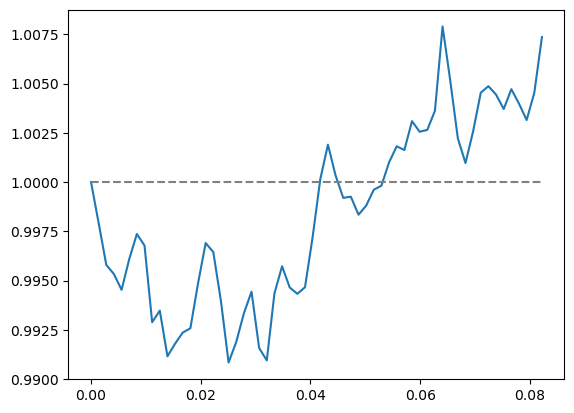

In [2]:
torch.manual_seed(0)
batch_x, batch_y, timesteps, d = 1200, 100, 60, 1
sigma, strike, S0, T = 0.05, 1.0, 1.0, 30./365 # Black Scholes parameters


dt = T/timesteps
time_grid = torch.linspace(0.0, T, timesteps).view(1, -1, 1).expand([batch_x + batch_y, timesteps, d])

dW = np.sqrt(dt)*torch.randn(batch_x + batch_y, timesteps-1, d)
W = torch.cat((torch.zeros(batch_x + batch_y, 1, d), dW.cumsum(dim=1)), dim = 1)
S = S0*torch.exp(-0.5*(sigma**2)*time_grid + sigma*W).to(device)

train_paths = S[:batch_x]
test_paths = S[batch_x:]

plt.plot(torch.linspace(0.0, T, timesteps), S[0].detach().cpu())
plt.plot(torch.linspace(0.0, T, timesteps), strike*torch.ones(timesteps), '--', color = 'grey')
plt.show()

## Utils

In [76]:
import scipy.stats as scipy
from scipy.stats import norm

#Blackscholes price

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))


strike_K = strike
def EuropeanCall(S):
  S = S.cpu()
  temp_fn = np.vectorize(lambda x : torch.max(torch.tensor([x - strike_K, 0.0])))
  return torch.tensor(temp_fn(S[:, -1, :])).to(device)


def delta_hedge(ttm, strike, sigma, r, curr_price):
  temp = torch.log(curr_price.cpu()/strike) + (r + 0.5*sigma**2)*ttm
  temp = temp/(sigma*np.sqrt(ttm))
  return  torch.tensor(norm.cdf(temp)).to(device)

priceBS = BS(S0,strike,T,sigma)
print('Price of a Call option in the Black scholes model with initial price', S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))

delta_hedge_ = torch.zeros(test_paths[:,:,0].shape).to(device)
for j in range(test_paths.shape[0]):
    for i in range(test_paths.shape[1]):
        ttm = T - i*T/timesteps
        delta_hedge_[j, i] = delta_hedge(ttm, strike, sigma, 0.0, test_paths[j,i,0])

Price of a Call option in the Black scholes model with initial price 1.0 strike 1.0 maturity 0.0821917808219178 and volatility 0.05 is equal to 0.0057186108908512945


In [77]:
def plot_results(test_index, kernel_hedge, delta_hedge, sign = 1):
    
    figure(figsize=(15, 12), dpi=80)
    
    kernel_position = kernel_hedge.position[test_index].detach().cpu()
    kernel_eta = kernel_hedge.eta[0, test_index].detach().cpu()
    delta = sign*delta_hedge[test_index].cpu()

    difference = delta[0] - kernel_position[0,0]
    print('Difference:', difference)

    plt.subplot(2, 2, 1)
    plt.plot(kernel_position, label='kernel')
    #plt.plot(kernel_position + difference, color='red', label='kernel + shift')
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(kernel_eta, label='eta')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(kernel_position, label='kernel')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.show()
    
def plot_results_old(test_index, kernel_hedge, delta_hedge, sign = 1):
    
    figure(figsize=(15, 12), dpi=80)
    
    kernel_position = kernel_hedge.position[test_index].detach().cpu()
    kernel_eta = kernel_hedge.eta[test_index, 0].detach().cpu()
    delta = sign*delta_hedge[test_index].cpu()

    difference = delta[0] - kernel_position[0,0]
    print('Difference:', difference)

    plt.subplot(2, 2, 1)
    plt.plot(kernel_position, label='kernel')
    #plt.plot(kernel_position + difference, color='red', label='kernel + shift')
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(kernel_eta, label='eta')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(kernel_position, label='kernel')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.show()
    
def plot_results_zoom(test_index, kernel_hedge, delta_hedge, sign = 1):
    
    figure(figsize=(15, 12), dpi=80)
    
    kernel_position = kernel_hedge.position[test_index].detach().cpu()
    delta = sign*delta_hedge[test_index].cpu()

    difference = delta[0] - kernel_position[0,0]
    print('Difference:', difference)

    plt.subplot(2, 1, 1)
    plt.plot(kernel_position, label='kernel')
    plt.plot(kernel_position + difference, color='red', label='kernel + shift')
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.show()

## SigKer

In [78]:
class SigKer(KernelCompute):
    def __init__(self):
        self.dyadic_order = 0
        self.Kernel_Class = sigkernel.SigKernel(sigkernel.LinearKernel(), dyadic_order=self.dyadic_order)
        self.scale = .5
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(self.scale*X.double(),self.scale*Y.double(), sym=sym)[..., ::2**self.dyadic_order, ::2**self.dyadic_order]
    
    def eta_square(self, X, time_augmented=False, max_batch=50):
        return super().eta_square(X, time_augmented, max_batch)

In [79]:
Ker = SigKer()

sk_hedge = SigKernelHedger(Ker,
                           EuropeanCall, priceBS, 
                           device, time_augment=True,
                           dyadic_order=0)

sk_hedge.pre_fit(train_paths)

In [80]:
# Without corrections

# 2e-8
sk_hedge.fit(regularisation=2e-8*sk_hedge.Xi.norm())
sk_hedge.compute_pnl(test_paths)

plot_results(2, sk_hedge, delta_hedge_)

Alpha Obtained: 0.05050802230834961


KeyboardInterrupt: 

Alpha Obtained: 0.0014290809631347656
Test PnL Obtained: 0.0010957717895507812
Difference: tensor(0.0316, dtype=torch.float64)


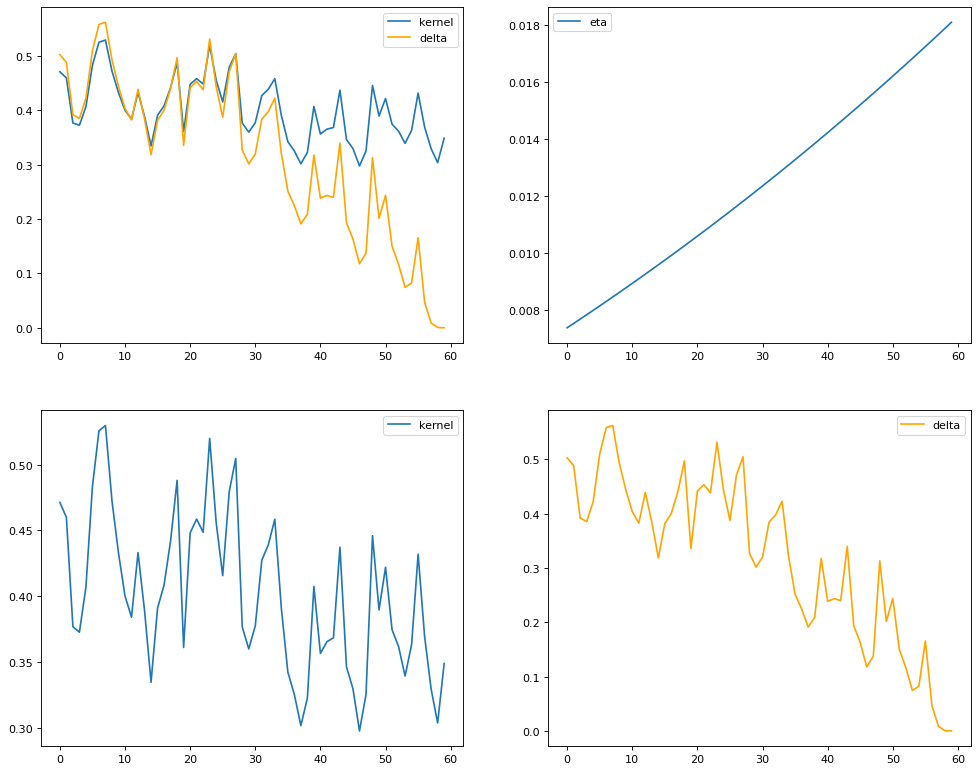

In [8]:
# With corrections

# 2e-8
sk_hedge.fit(regularisation=.1e-4*sk_hedge.Xi.norm())
sk_hedge.compute_pnl(test_paths)

plot_results(3, sk_hedge, delta_hedge_)

## New

In [16]:
class ItoSigKer(KernelCompute):
    def __init__(self):
        self.Kernel_Class = src.Ito_SigKer.ItoKer()
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(X,Y)
    
    def eta_square(self, X, time_augmented=False, max_batch=50):
        return super().eta_square(X, time_augmented, max_batch)

In [17]:
Ker = ItoSigKer()

sk_hedge = SigKernelHedger(Ker,
                           EuropeanCall, priceBS, 
                           device, time_augment=True,
                           dyadic_order=0)

sk_hedge.pre_fit(train_paths)

100%|██████████| 59/59 [00:01<00:00, 34.42it/s] 


Alpha Obtained: 0.003165006637573242
Test PnL Obtained: 0.0007479190826416016
Difference: tensor(0.0317, dtype=torch.float64)


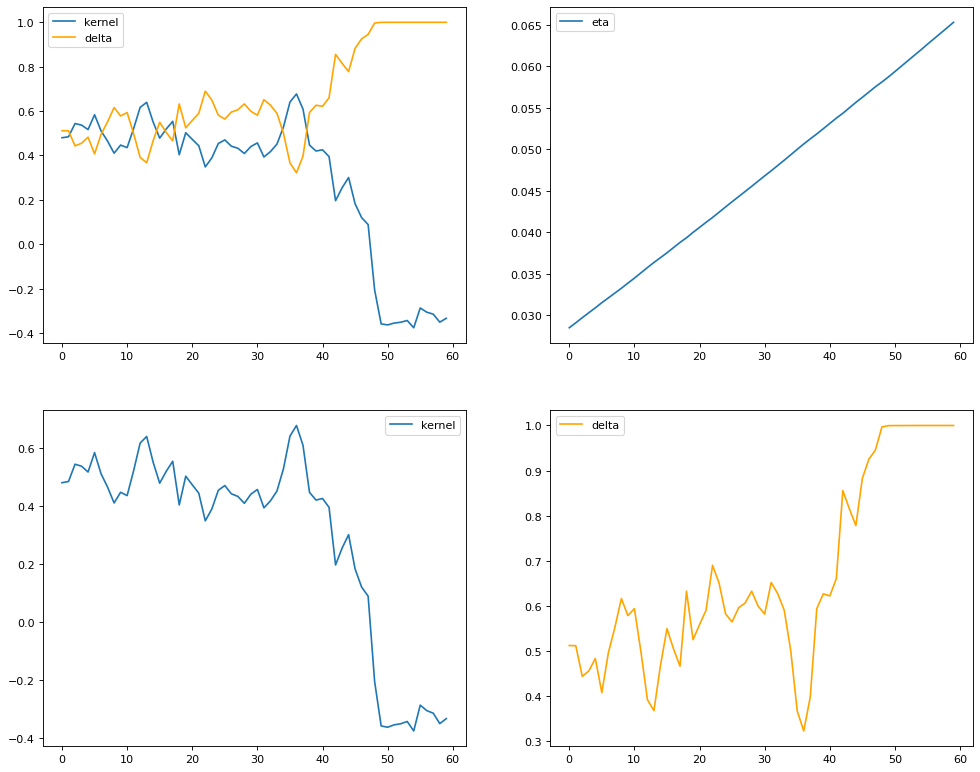

In [32]:
sk_hedge.fit(regularisation=.1e-4*sk_hedge.Xi.norm())
sk_hedge.compute_pnl(test_paths)

plot_results(1, sk_hedge, delta_hedge_)

Alpha Obtained: 0.0042879581451416016
Test PnL Obtained: 0.0009348392486572266
Difference: tensor(-0.0207, dtype=torch.float64)


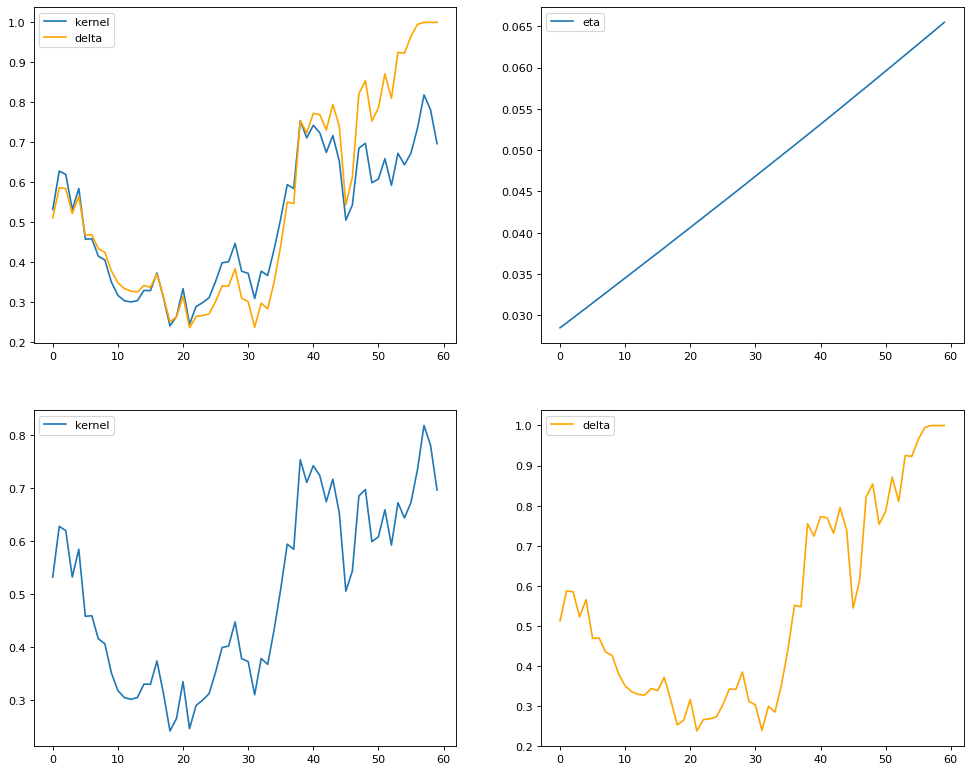

In [ ]:
sk_hedge.fit(regularisation=3e-10)
sk_hedge.compute_pnl(test_paths)

plot_results(1, sk_hedge, delta_hedge_)

## New "Fast"

In [ ]:
class ItoSigKer_fast(KernelCompute):
    def __init__(self):
        self.Kernel_Class = src.Ito_SigKer.ItoKer()
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(X,Y)
    
    def _compute_eta(self, X: torch.Tensor, Y: torch.Tensor, time_augmented=False) -> torch.Tensor:
        return self.Kernel_Class.compute_Gram_and_eta(X, Y, time_augment=time_augmented, max_batch=20)[1]
    
    def _compute_eta_square(self, X: torch.Tensor, time_augmented=False) -> torch.Tensor:
        return self.Kernel_Class.compute_Gram_and_eta_square(X, X, sym=True, time_augment=time_augmented, max_batch=20)[1]

Ker_fast = ItoSigKer_fast()

In [ ]:
sk_hedge_fast = SigKernelHedger(Ker_fast,
                                EuropeanCall, priceBS, 
                                device, time_augment=True,
                                dyadic_order=1)

sk_hedge_fast.pre_fit(train_paths)

100%|██████████| 118/118 [00:06<00:00, 17.31it/s]


Alpha Obtained: 0.0018019676208496094


100%|██████████| 118/118 [00:04<00:00, 26.68it/s]


Test PnL Obtained: 0.0002281665802001953
Difference: tensor(0.0064, dtype=torch.float64)


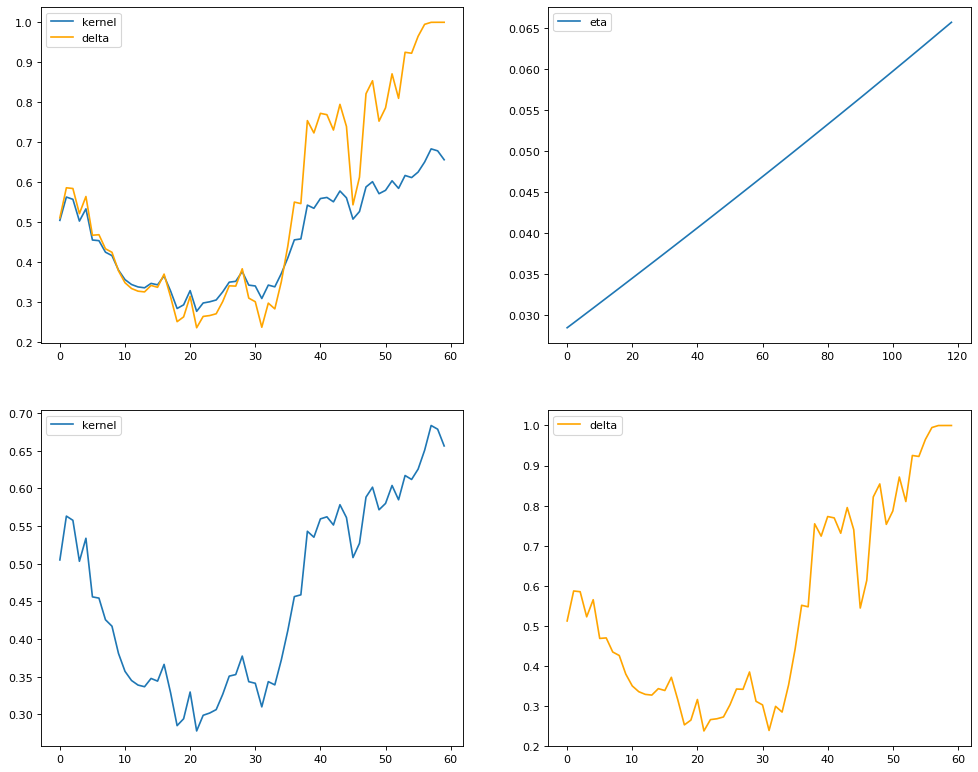

In [ ]:
sk_hedge_fast.fit(reg_type='L2', regularisation=3e-17)
sk_hedge_fast.compute_pnl(test_paths)

plot_results(1, sk_hedge_fast, delta_hedge_)


## Fast and Hoff

In [ ]:
class ItoSigKer_Hoff(KernelCompute):
    def __init__(self):
        self.Kernel_Class = src.Ito_SigKer.ItoKer()
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(X,Y)
    
    def _compute_eta(self, X: torch.Tensor, Y: torch.Tensor, time_augmented=False) -> torch.Tensor:
        return self.Kernel_Class._compute_Gram_and_eta_Hoff(X, Y, time_augmented)[1]
    
    def _compute_eta_square(self, X: torch.Tensor, time_augmented=False) -> torch.Tensor:
        return self.Kernel_Class._compute_Gram_and_eta_square_Hoff(X, time_augmented)[1]

Ker_Hoff = ItoSigKer_Hoff()

In [ ]:
sk_hedge_Hoff = SigKernelHedger(Ker_Hoff,
                                EuropeanCall, priceBS, 
                                device, time_augment=True)

sk_hedge_Hoff.pre_fit(train_paths)

100%|██████████| 235/235 [00:53<00:00,  4.40it/s]


Alpha Obtained: 0.004405021667480469
Test PnL Obtained: 0.0012679100036621094
Difference: tensor(0.0113, dtype=torch.float64)


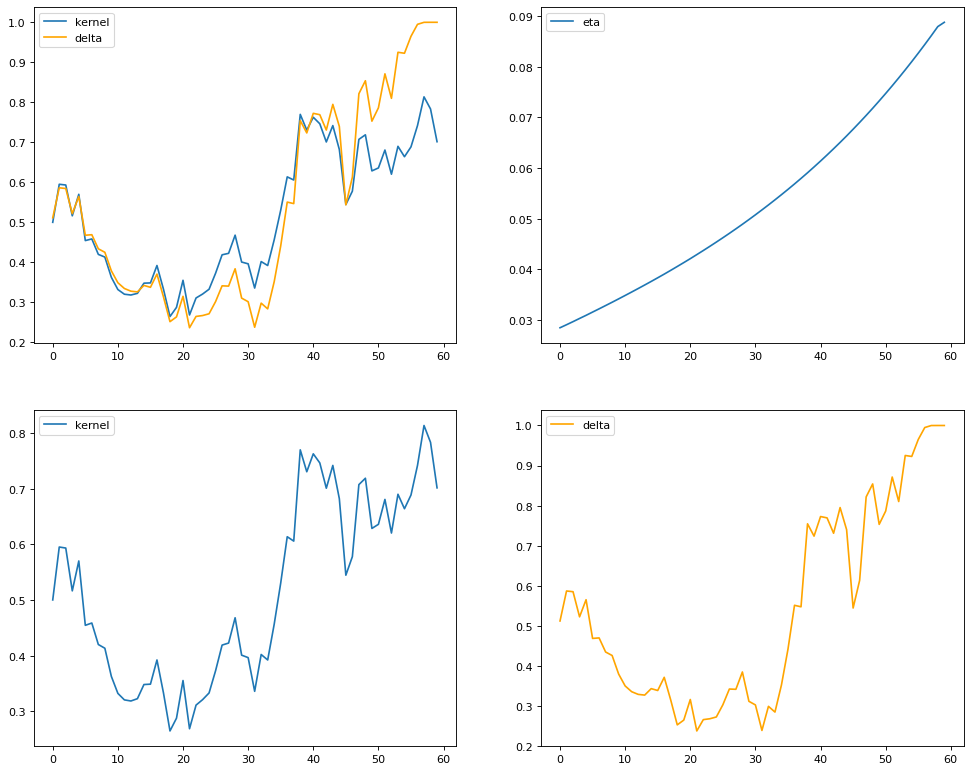

In [ ]:
sk_hedge_Hoff.fit(reg_type='L2', regularisation=3e-16)
sk_hedge_Hoff.compute_pnl(test_paths)

plot_results(1, sk_hedge_Hoff, delta_hedge_)

## Exact

In [ ]:
class ItoSigKer_exact(KernelCompute):
    def __init__(self):
        self.Kernel_Class = src.Ito_SigKer.ItoKer()
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(X,Y)
    
    def _compute_eta(self, X: torch.Tensor, Y: torch.Tensor, time_augmented=False) -> torch.Tensor:
        return self.Kernel_Class._compute_Gram_and_eta(X, Y, time_augmented)[1]
    
    def _compute_eta_square(self, X: torch.Tensor, time_augmented=False) -> torch.Tensor:
        K = self.Kernel_Class.compute_Gram_and_eta_square(X, X, sym=True, time_augment=time_augmented)[0]
        return K - torch.ones(K.shape, device=K.device.type)

In [ ]:
Ker_exact = ItoSigKer_exact()

sk_hedge_exact = SigKernelHedger(Ker_exact,
                           EuropeanCall, priceBS, 
                           device, time_augment=True,
                           dyadic_order=2)

sk_hedge_exact.pre_fit(train_paths)

100%|██████████| 236/236 [00:25<00:00,  9.18it/s]


Alpha Obtained: 0.004152059555053711


100%|██████████| 236/236 [00:20<00:00, 11.38it/s]


Test PnL Obtained: 0.00040793418884277344
Difference: tensor(0.1427, dtype=torch.float64)


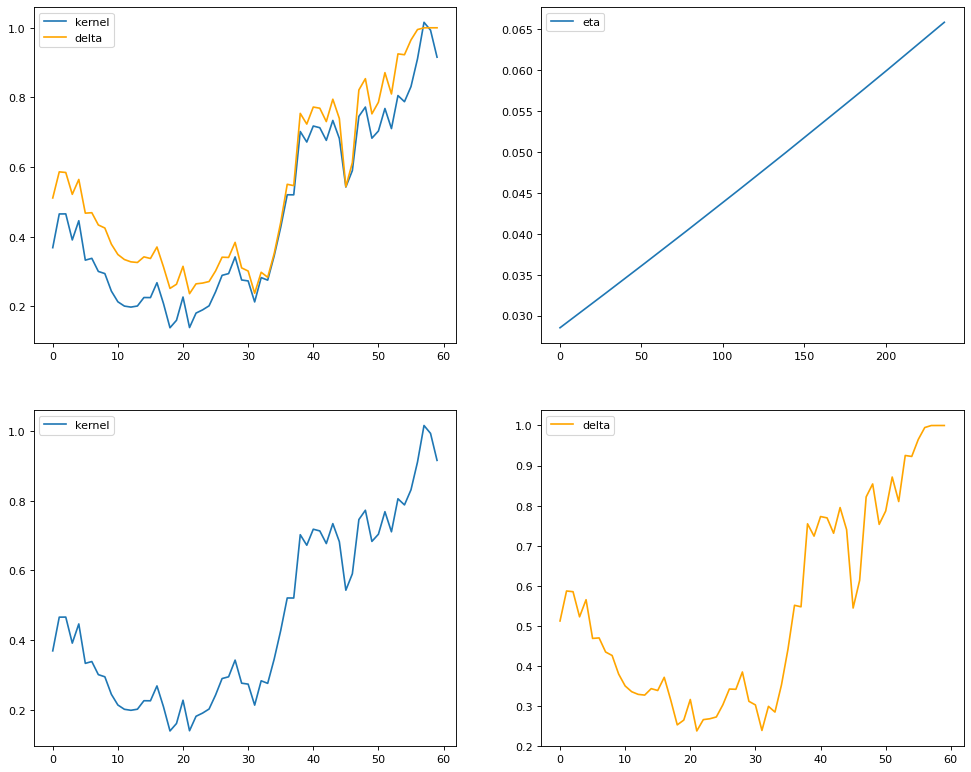

In [ ]:
sk_hedge_exact.fit(reg_type='L2', regularisation=7e-12)
sk_hedge_exact.compute_pnl(test_paths)

plot_results(1, sk_hedge_exact, delta_hedge_)

# Final Results

In [25]:
def print_loss_and_comparison(hedge_pnl, delta_pnl):
    
    # Compute losses
    sqrt_loss = (EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS  + hedge_pnl[:,-1].detach().cpu()))
    sqrt_loss_delta = (EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS + delta_pnl[:,-1]))
    loss = (sqrt_loss**2).mean()

    print('Expected OOS Loss: %s' % float(loss))
    print('Mean sqrtLoss: %s' % float(sqrt_loss.mean()))
    
    # Comparison Plot
    plt.hist(sqrt_loss, density=True, bins=20, label='kernel')
    plt.hist(sqrt_loss_delta, density=True, bins=20, label='delta')  

    plt.ylabel('Probability')
    plt.xlabel('Z - pi_0 - (H.S)_T')

    plt.legend()
    plt.show()

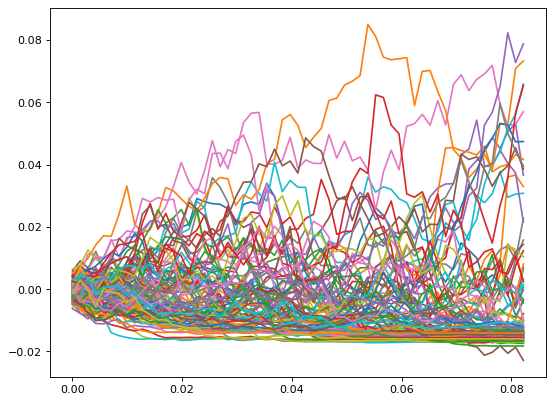

In [26]:
delta_hedge_all = torch.zeros((batch_y, timesteps))

for i in range(batch_y):
  delta_hedge_i = torch.zeros(timesteps-1)
  for t in range(timesteps-1):
    ttm = T - t*T/timesteps
    delta_hedge_i[t] = delta_hedge(ttm, strike, sigma, 0.0, test_paths[i,t,0])

  delta_hedge_all[i, 1:] = (test_paths[i].squeeze(-1).diff().cpu()*delta_hedge_i).cumsum(dim=0)



figure(figsize=(8, 6), dpi=80)
for i in range(batch_y):
  plt.plot(torch.linspace(0.0, T, timesteps-1), delta_hedge_all[i][1:])

Delta Hedge Loss

In [27]:
sqrt_loss_delta = (EuropeanCall(test_paths).detach().cpu().squeeze(-1) - (priceBS + delta_hedge_all[:,-1]))
loss_delta = (sqrt_loss_delta**2).mean()

print('Expected OOS Delta_Loss: %s' % float(loss_delta))
print('Mean Delta_sqrtLoss: %s' % float(sqrt_loss_delta.mean()))     

Expected OOS Delta_Loss: 6.23573061383663e-06
Mean Delta_sqrtLoss: 7.340449839830398e-05


## Original

Expected OOS Loss: 4.5973557495558495e-05
Mean sqrtLoss: 5.308108754007668e-05


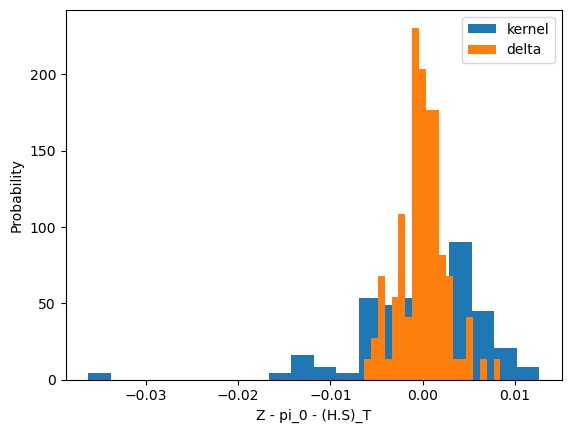

In [28]:
print_loss_and_comparison(sk_hedge.pnl, delta_hedge_all)

Expected OOS Loss: 3.1877333126694984e-05
Mean sqrtLoss: 0.00026031547054703054


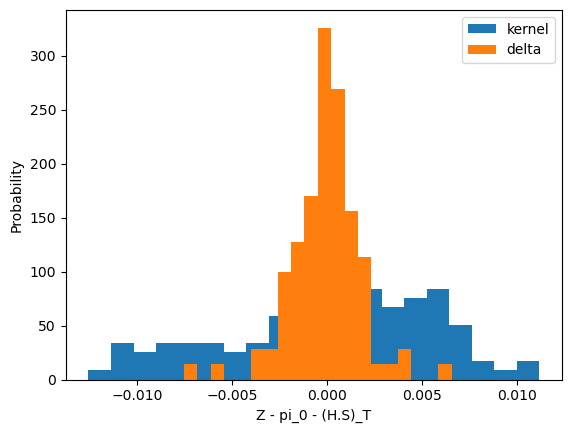

In [63]:
print_loss_and_comparison(sk_hedge.pnl, delta_hedge_all)

## Fast

In [ ]:
print_loss_and_comparison(sk_hedge_fast.pnl, delta_hedge_all)

## Hoff

Expected OOS Loss: 9.683544357657657e-05
Mean sqrtLoss: -0.0008302613043215674


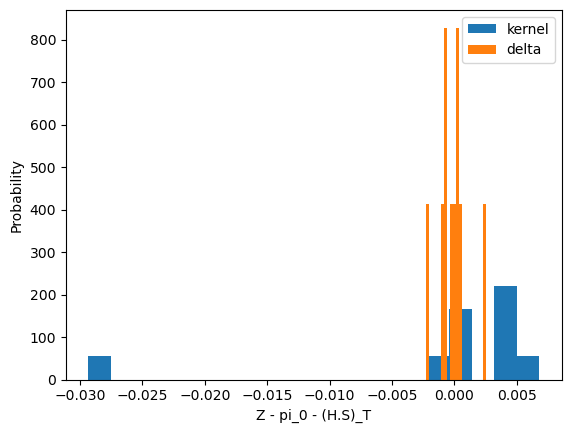

In [ ]:
print_loss_and_comparison(sk_hedge_Hoff.pnl, delta_hedge_all)

## Exact

Expected OOS Loss: 0.0006357248947081597
Mean sqrtLoss: -0.016504706132572197


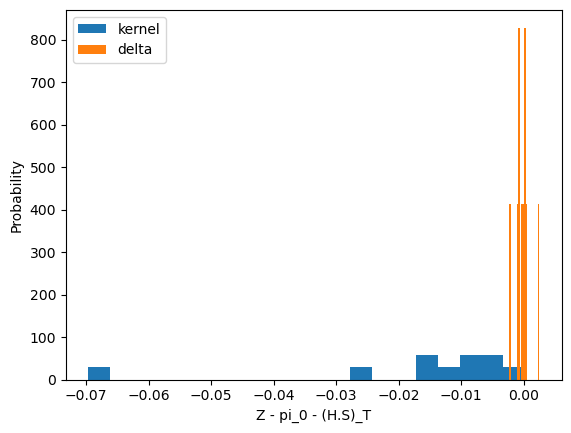

In [ ]:
print_loss_and_comparison(sk_hedge_exact.pnl, delta_hedge_all)